*italicized text*# Inertial Estimation with Imu Preintegration

<a href="https://colab.research.google.com/github/gtbook/gtsam-examples/blob/main/ImuFactorExample101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Background

IMUs are powerful sensors capable of providing us with measurements on angular velocity and linear acceleration of the body at high frequencies (~200Hz and above). To estimate the pose of the body at any time, one can simply integrate the angular velocity to get the rotation and double-integrate the linear acceleration to get the velocity and translation.

$$ R^w_b(t_j) = R^w_b(t_i)\int^{t_j}_{t_i} exp(\hat{\omega}(t)) dt $$
$$ v^w(t_j) = v^w(t_i) + \int^{t_j}_{t_i} \hat{a} dt $$
$$ t^w(t_j) = \int^{t_j}_{t_i} \left( v^w(t_i) \int^{t_j}_{t_i} \hat{a}\right) dt $$

where $\hat{\omega}$ is the measured angular velocity and $\hat{a}$ is the measured linear acceleration.

Alas, things are not as straightforward as this. Unless you are using tactical or navigation grade IMUs (which cost \$1000s), the sensor measurements will be noisy and affected by sensor bias $(b_{\omega}, b_{a})$ that will cause the estimates to drift away from the true values. To correct for this, we need to optimize with consideration for the noise and bias values as part of our model.

However, performing optimization at 200 Hz is a bit unrealistic and can quickly overwhelm the system, especially when we only need estimates every, e.g. 50 Hz. Can we instead account for multiple measurements between two estimation timestamps as a single binary constraint? The answer is yes and the methodology for that is developed in the [paper by Lupton and Sukkarieh](https://ieeexplore.ieee.org/document/5354267) and improved upon [by Forster et. al.](https://arxiv.org/pdf/1512.02363.pdf) which is termed as **IMU Preintegration**.

Luckily for us, GTSAM has the `ImuFactor` which performs IMU preintegration for us in a neatly tied package, such that all we need to consider is the coordinate frame of the sensor with respect to the body, and providing the measurements for preintegration.

## Objectives

In this example, we shall examine how to use IMU preintegration for inertial estimation with factor graphs. Given a sequence of measurements, we will construct the factor graph and optimize it in order to get the desired pose estimates.

In [1]:
# Install the pre-requisites
%pip -q install gtbook ipympl  # also installs latest gtsam pre-release

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.7/515.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.7 MB/s eta 0:00:00


In [37]:
# All the imports we need
import numpy as np
import gtsam
from gtsam.utils.plot import plot_pose3
from matplotlib import pyplot as plt
from gtsam.symbol_shorthand import B, V, X
from gtbook.display import show
from mpl_toolkits.mplot3d import Axes3D

try:
  # For Google Colab
  from google.colab import output
  output.enable_custom_widget_manager()
  print(" -- Custom widgets enabled")
except:
  pass

# For interactive plots


 -- Custom widgets enabled


## Example Trajectory

Let's first generate an example trajectory we wish to estimate, as this will give us a good sense of what we want. We'll also visualize the trajectory with a little helper function.

In [4]:
T = 12  # The timespan of our trajectory.
dt = 1e-2  # 100 Hz frequency
velocity = np.array([2, 0, 0])  # The velocity we wish to move at.

scenarios = {
    "zero_twist": (np.zeros(3), np.zeros(3)),  # Zero motion, stationary trajectory.
    "forward_motion": (np.zeros(3), velocity),  # Move forward in the x axis at 2 m/s.
    "loop": (np.array([0, -np.radians(30), 0]), velocity),  # A loop-de-loop trajectory.
    "sick": (np.array([np.radians(30), -np.radians(30), 0]), velocity)  # A spiral trajectory, "sick" in surfer slang.
}


def plot_scenario(scenario,
                  T,
                  dt,
                  title="IMU trajectory scenario",
                  fignum=0,
                  maxDim=5):
    for t in np.arange(0, T, dt):
        actualPose = scenario.pose(t)
        plot_pose3(fignum, actualPose, axis_length=0.3)

        translation = actualPose.translation()
        maxDim = max([max(np.abs(translation)), maxDim])
        ax = plt.gca()
        ax.set_xlim3d(-maxDim, maxDim)
        ax.set_ylim3d(-maxDim, maxDim)
        ax.set_zlim3d(-maxDim, maxDim)
        ax.set_title(title)

    plt.show()

We can now plot the various scenarios, e.g. forward motion.

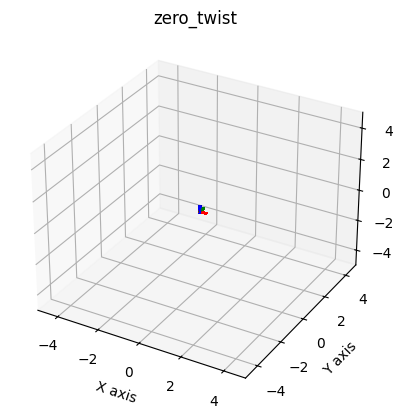

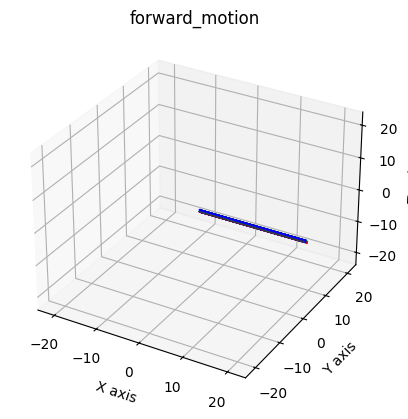

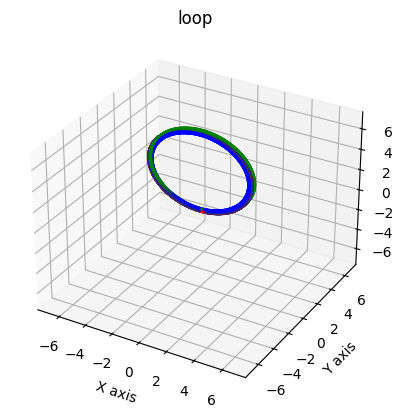

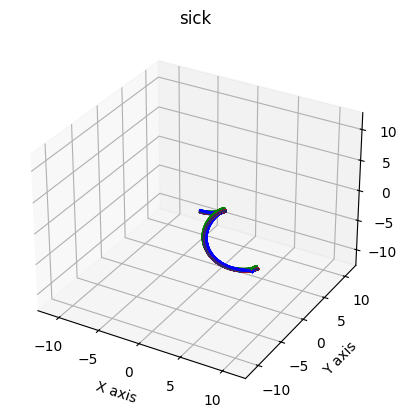

In [5]:
for idx, scenario_name in enumerate(scenarios.keys()):
    scenario = gtsam.ConstantTwistScenario(*scenarios[scenario_name])
    plot_scenario(scenario, T, dt, fignum=idx + 1, title=scenario_name)


Let's start with a simple trajectory to make understanding easier, so we will pick the __forward motion__ trajectory. As you will see later, the same approach works for all trajectories.

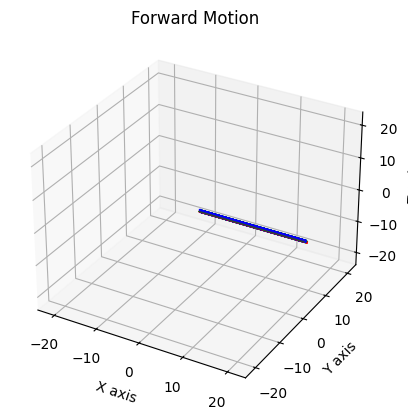

In [6]:
scenario = gtsam.ConstantTwistScenario(*scenarios["forward_motion"])

# Let's visualize it for our '''  '''understanding
plot_scenario(scenario, T, dt, title="Forward Motion", fignum=5)

As a  final step in creating the example, we need to define the IMU biases.

In [7]:
accBias = np.array([-0.3, 0.1, 0.2])
gyroBias = np.array([0.1, 0.3, -0.1])
actualBias = gtsam.imuBias.ConstantBias(accBias, gyroBias)


In [38]:
# prompt: read the imu data file from data.csv from drive

import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

# Replace 'Your_file_path' with the actual path to your data.csv file in Google Drive
file_path = '/content/drive/MyDrive/data.csv'

try:
  imu_data = pd.read_csv(file_path)
  print("IMU data loaded successfully:")
  print(imu_data.head()) # Print first few rows of the dataframe
except FileNotFoundError:
  print(f"Error: File not found at {file_path}")
except pd.errors.ParserError:
  print(f"Error: Could not parse the CSV file at {file_path}. Check the file format.")
except Exception as e:
  print(f"An unexpected error occurred: {e}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
IMU data loaded successfully:
       #timestamp [ns]  w_RS_S_x [rad s^-1]  w_RS_S_y [rad s^-1]  \
0  1403636579758555392            -0.099135             0.147306   
1  1403636579763555584            -0.099135             0.140324   
2  1403636579768555520            -0.098437             0.127758   
3  1403636579773555456            -0.102625             0.115890   
4  1403636579778555392            -0.105418             0.108210   

   w_RS_S_z [rad s^-1]  a_RS_S_x [m s^-2]  a_RS_S_y [m s^-2]  \
0             0.027227           8.147692          -0.375922   
1             0.029322           8.033281          -0.408610   
2             0.037699           7.886181          -0.424955   
3             0.045379           7.828976          -0.375922   
4             0.051662           7.714565          -0.408610   

   a_RS_S_z [m s^-2]  
0          -2.402629  
1

## IMU Preintegration

To perform preintegration, GTSAM conveniently provides us with an object called `PreintegratedImuMeasurements`. This object requires various parameters such as the sensor covariances, an initial estimate of the bias, and a potential tranform `bodyPsensor` is the IMU is not coincidental with the body frame.

We begin with specifying that the IMU has the Z axis pointing up. This is important since reaction to gravity is an acceleration that is measured by the IMU, and making a mistake here can throw our entire system into jeopardy easily. We also specify some nominal covariance values, though these would depend on the IMU itself.

 Also, let's create a `ScenarioRunner` which is a helper object to get us the measurements as well as other parameters we need during the main data loop.

In [39]:
# Extracted values from EuRoC sensor.yaml (use actual values if available)
gyro_sigma = 1.6968e-04  # Gyroscope noise density (rad/s/√Hz)
accel_sigma = 2.0000e-3  # Accelerometer noise density (m/s²/√Hz)
integration_sigma = 1e-5  # Integration noise (arbitrary small value)
gravity = 9.81  # Gravity magnitude

# Initialize IMU Preintegration Parameters
pim_params = gtsam.PreintegrationParams.MakeSharedU(gravity)

I_3x3 = np.eye(3)
pim_params.setGyroscopeCovariance(gyro_sigma**2 * I_3x3)
pim_params.setAccelerometerCovariance(accel_sigma**2 * I_3x3)
pim_params.setIntegrationCovariance(integration_sigma**2 * I_3x3)

# Use a zero bias if not defined
actualBias = gtsam.imuBias.ConstantBias()  # Bias can be optimized later

# Initialize Preintegrated IMU Measurements
pim = gtsam.PreintegratedImuMeasurements(pim_params, actualBias)

prev_time = imu_data["#timestamp [ns]"].iloc[0] * 1e-9  # Convert ns to seconds

for i in range(1, len(imu_data)):
    t = imu_data["#timestamp [ns]"].iloc[i] * 1e-9
    dt = t - prev_time
    prev_time = t

    gyro = imu_data.iloc[i][['w_RS_S_x [rad s^-1]', 'w_RS_S_y [rad s^-1]', 'w_RS_S_z [rad s^-1]']].values
    accel = imu_data.iloc[i][['a_RS_S_x [m s^-2]', 'a_RS_S_y [m s^-2]', 'a_RS_S_z [m s^-2]']].values

    pim.integrateMeasurement(accel, gyro, dt)


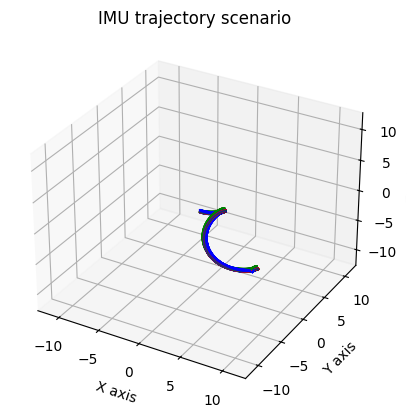

In [21]:
pim_params = gtsam.PreintegrationParams.MakeSharedU(9.81)

# Some arbitrary noise sigmas
gyro_sigma = 1e-3
accel_sigma = 1e-3
I_3x3 = np.eye(3)
pim_params.setGyroscopeCovariance(gyro_sigma**2 * I_3x3)
pim_params.setAccelerometerCovariance(accel_sigma**2 * I_3x3)
pim_params.setIntegrationCovariance(1e-7**2 * I_3x3)

# Define the PreintegratedImuMeasurements object here.
pim = gtsam.PreintegratedImuMeasurements(pim_params, actualBias)

runner = gtsam.ScenarioRunner(scenario, pim_params, dt, actualBias)
plot_scenario(scenario, T, dt, fignum=6)

We can define our main loop, where we accept the IMU measurements and create our `ImuFactor`s by preintegrating the measurements.

In [9]:
def main_loop(runner, scenario, graph, initial, T):
    # The factor index for the estimation rate
    i = 0

    for k, t in enumerate(np.arange(0, T, dt)):
        # get measurements and add them to PIM
        measuredOmega = runner.measuredAngularVelocity(t)
        measuredAcc = runner.measuredSpecificForce(t)

        ### This is where all the magic happens!
        pim.integrateMeasurement(measuredAcc, measuredOmega, dt)

        if (k + 1) % int(1 / dt) == 0:
            # Create IMU factor every second.
            factor = gtsam.ImuFactor(X(i), V(i), X(i + 1), V(i + 1), B(0), pim)
            graph.push_back(factor)

            # We have created the binary constraint, so we clear out the preintegration values.
            pim.resetIntegration()

            # Get the true state which we will corrupt with some additive noise terms defined below
            actual_state_i = scenario.navState(t + dt)

            # These are additive noise terms.
            rotationNoise = gtsam.Rot3.Expmap(np.random.randn(3) * 0.1)
            translationNoise = gtsam.Point3(*np.random.randn(3) * 1)
            poseNoise = gtsam.Pose3(rotationNoise, translationNoise)

            noisy_state_i = gtsam.NavState(
                actual_state_i.pose().compose(poseNoise),
                actual_state_i.velocity() + np.random.randn(3) * 0.1)

            initial.insert(X(i + 1), noisy_state_i.pose())
            initial.insert(V(i + 1), noisy_state_i.velocity())
            i += 1

    return graph, initial

In [40]:
def main_loop(imu_data, graph, initial):
    i = 0  # Factor index

    prev_time = imu_data["timestamp"].iloc[0] * 1e-9  # Convert ns to seconds
    pim.resetIntegration()  # Ensure PIM starts fresh

    for k in range(1, len(imu_data)):
        # Get current time and compute time difference
        t = imu_data["timestamp"].iloc[k] * 1e-9
        dt = t - prev_time
        prev_time = t

        # Get IMU measurements from CSV
        measuredOmega = imu_data.iloc[k][["w_x", "w_y", "w_z"]].values
        measuredAcc = imu_data.iloc[k][["a_x", "a_y", "a_z"]].values

        # Integrate the IMU measurement
        pim.integrateMeasurement(measuredAcc, measuredOmega, dt)

        if (k + 1) % int(1 / dt) == 0:  # Create IMU factor every second
            factor = gtsam.ImuFactor(X(i), V(i), X(i + 1), V(i + 1), B(0), pim)
            graph.push_back(factor)
            pim.resetIntegration()  # Reset after adding a new factor

            # No ground truth from "scenario", so use estimated state (optional)
            noisy_state_i = gtsam.NavState(
                gtsam.Pose3(gtsam.Rot3(), gtsam.Point3(0, 0, 0)),  # Identity pose
                np.zeros(3)  # Zero velocity (adjust if needed)
            )

            initial.insert(X(i + 1), noisy_state_i.pose())
            initial.insert(V(i + 1), noisy_state_i.velocity())
            i += 1

    return graph, initial


## Factor Graph

We are now ready to generate our factor graph. The `scenario` object will provide us with the measurements, and we will add a prior on the pose and the velocity to ensure our graph is not singular.

In [41]:
graph = gtsam.NonlinearFactorGraph()
initial = gtsam.Values()

Let's add in the priors to our graph as well as some initial estimates.

In [31]:
def add_priors(scenario, graph, initial):
    # Noise models for
    priorNoise = gtsam.noiseModel.Isotropic.Sigma(6, 0.1)
    velNoise = gtsam.noiseModel.Isotropic.Sigma(3, 0.1)

    initial_state = scenario.navState(0)
    graph.push_back(
        gtsam.PriorFactorPose3(X(0), initial_state.pose(), priorNoise))
    graph.push_back(
        gtsam.PriorFactorVector(V(0), initial_state.velocity(), velNoise))

    initial.insert(B(0), actualBias)
    initial.insert(X(0), initial_state.pose())
    initial.insert(V(0), initial_state.velocity())

    return graph, initial


graph, initial = add_priors(scenario, graph, initial)


Now with everything set up, we can run our main loop.

In [32]:
graph, initial = main_loop(runner, scenario, graph, initial, T)

TypeError: main_loop() takes 3 positional arguments but 5 were given

In [44]:
graph = gtsam.NonlinearFactorGraph()
initial = gtsam.Values()
imu_data.rename(columns={'#timestamp [ns]': 'timestamp'}, inplace=True)
imu_data.rename(columns={
    'w_RS_S_x [rad s^-1]': 'w_x',
    'w_RS_S_y [rad s^-1]': 'w_y',
    'w_RS_S_z [rad s^-1]': 'w_z',
    'a_RS_S_x [m s^-2]': 'a_x',
    'a_RS_S_y [m s^-2]': 'a_y',
    'a_RS_S_z [m s^-2]': 'a_z'
}, inplace=True)



def add_priors(imu_data, graph, initial):
    # Noise models
    priorNoise = gtsam.noiseModel.Isotropic.Sigma(6, 0.1)
    velNoise = gtsam.noiseModel.Isotropic.Sigma(3, 0.1)

    # Extract initial state from first row of IMU data
    initial_pose = gtsam.Pose3(gtsam.Rot3(), gtsam.Point3(0, 0, 0))  # Assuming identity pose
    initial_velocity = np.zeros(3)  # Assuming zero velocity (modify if needed)

    graph.push_back(gtsam.PriorFactorPose3(X(0), initial_pose, priorNoise))
    graph.push_back(gtsam.PriorFactorVector(V(0), initial_velocity, velNoise))

    # Insert initial values
    initial.insert(B(0), actualBias)
    initial.insert(X(0), initial_pose)
    initial.insert(V(0), initial_velocity)

    return graph, initial

# Load IMU data from CSV
file_path = '/content/drive/MyDrive/data.csv'
#imu_data = pd.read_csv(file_path)

# Add priors and run the main loop
graph, initial = add_priors(imu_data, graph, initial)
graph, initial = main_loop(imu_data, graph, initial)


We want to visualize our initial estimates, so let's create a small function to do so and plot out the initial trajectory based only on pure forward-integration. You will see that the initial estimates don't look like anything close to the true trajectory!

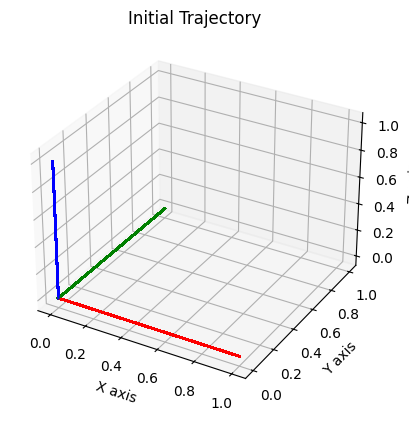

In [45]:
def plot_trajectory(values: gtsam.Values,
                    title: str = "Estimated Trajectory",
                    fignum: int = 1,
                    show: bool = False):
    i = 0
    while values.exists(X(i)):
        pose_i = values.atPose3(X(i))
        plot_pose3(fignum, pose_i, 1)
        i += 1
    plt.title(title)

    gtsam.utils.plot.set_axes_equal(fignum)

    plt.ioff()

    if show:
        plt.show()


plot_trajectory(initial, title="Initial Trajectory", fignum=7, show=True)

## Optimization

Now that we have a full factor graph and initial estimates, we can optimize for the correct estimates. This is as simple as just initializing an optimizer with the graph and initial values and calling `optimize` on it.

In [46]:
lm_params = gtsam.LevenbergMarquardtParams()
lm_params.setVerbosityLM("SUMMARY")
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, lm_params)
result = optimizer.optimize()

## Final Result

Now that we have our final `result` values, we can visualize the result and see that our estimates are actually quite good.

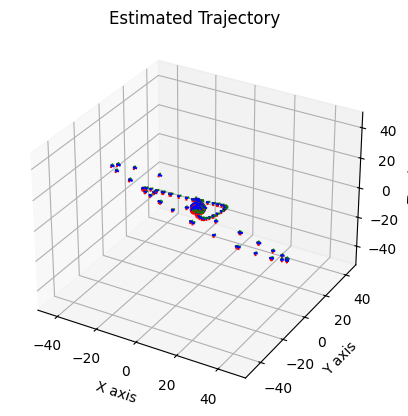

In [47]:
plot_trajectory(result, fignum=8, show=True)

In [52]:
import pandas as pd

def save_trajectory_to_csv(values: gtsam.Values,
                            filename: str = "trajectory.csv"):
    trajectory_data = []

    i = 0
    while values.exists(X(i)):
        pose_i = values.atPose3(X(i))  # Get the pose at index i
        position = pose_i.translation()  # Extract the position
        velocity = values.atVector(V(i))  # Extract velocity (if available)

        # Append position and velocity data to the list
        trajectory_data.append({
            'timestamp': i,  # You can add a custom timestamp based on your data
            'x': position[0],  # Access the x, y, z components directly from the ndarray
            'y': position[1],
            'z': position[2],
            'vx': velocity[0] if len(velocity) > 0 else 0,  # Default to 0 if no velocity
            'vy': velocity[1] if len(velocity) > 1 else 0,
            'vz': velocity[2] if len(velocity) > 2 else 0
        })

        i += 1

    # Create a DataFrame from the trajectory data
    trajectory_df = pd.DataFrame(trajectory_data)

    # Save the trajectory data to a CSV file
    trajectory_df.to_csv(filename, index=False)
    print(f"Trajectory saved to {filename}")

from google.colab import drive
drive.mount('/content/drive')

save_trajectory_to_csv(result, filename="/content/drive/MyDrive/optimized_trajectory.csv")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Trajectory saved to /content/drive/MyDrive/optimized_trajectory.csv


## Other Scenarios

We can similarly run the same code above for other scenarios.

### Standing Scenario

Let's use the `ImuFactorExample` for all the scenarios, starting with **Standing**.

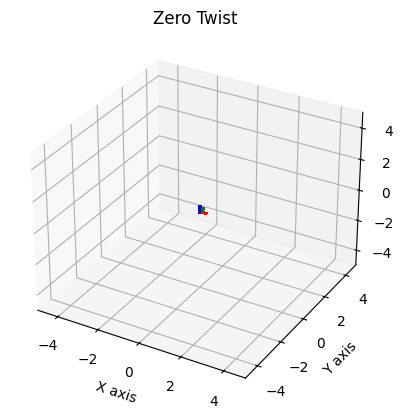

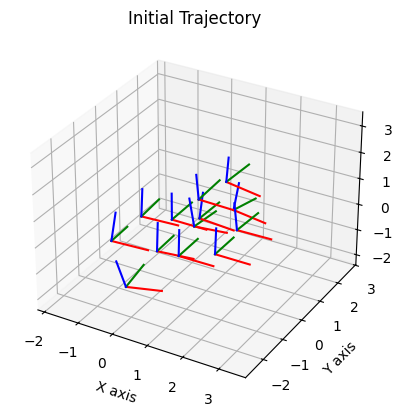

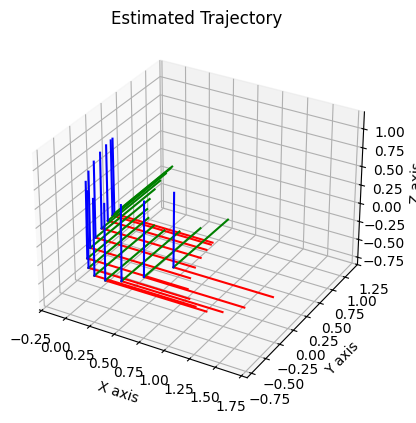

In [16]:
scenario = gtsam.ConstantTwistScenario(*scenarios["zero_twist"])
plot_scenario(scenario, T, dt, title="Zero Twist", fignum=9)

runner = gtsam.ScenarioRunner(scenario, pim_params, dt, actualBias)


graph = gtsam.NonlinearFactorGraph()
initial = gtsam.Values()

graph, initial = add_priors(scenario, graph, initial)
graph, initial = main_loop(runner, scenario, graph, initial, T)

optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, lm_params)
result = optimizer.optimize()

plot_trajectory(initial, title="Initial Trajectory", fignum=10, show=True)
plot_trajectory(result, fignum=11, show=True)

### Loop Scenario

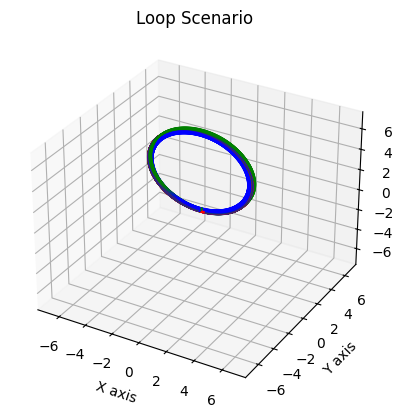

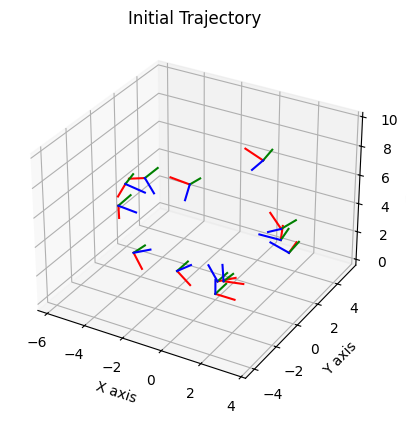

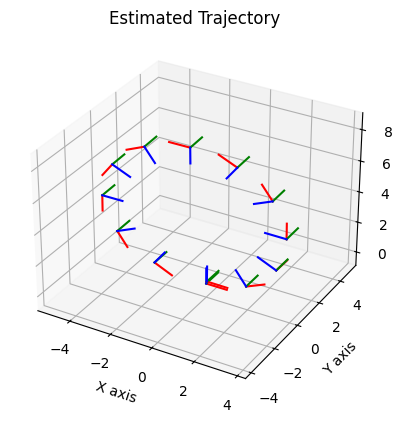

In [17]:
scenario = gtsam.ConstantTwistScenario(*scenarios["loop"])
plot_scenario(scenario, T, dt, title="Loop Scenario", fignum=12)

runner = gtsam.ScenarioRunner(scenario, pim_params, dt, actualBias)


graph = gtsam.NonlinearFactorGraph()
initial = gtsam.Values()

graph, initial = add_priors(scenario, graph, initial)
graph, initial = main_loop(runner, scenario, graph, initial, T)

optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, lm_params)
result = optimizer.optimize()

plot_trajectory(initial, title="Initial Trajectory", fignum=13, show=True)
plot_trajectory(result, fignum=14, show=True)

### Sick Scenario

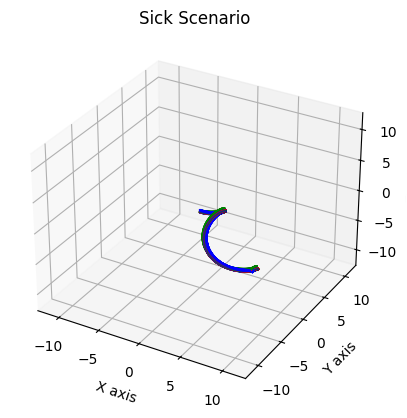

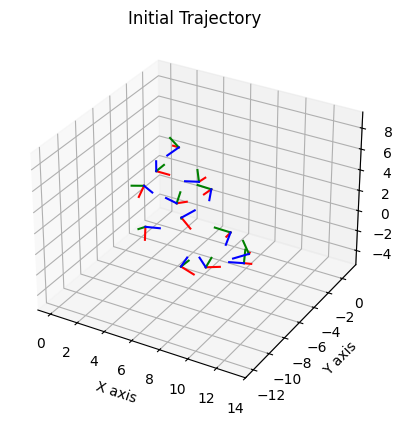

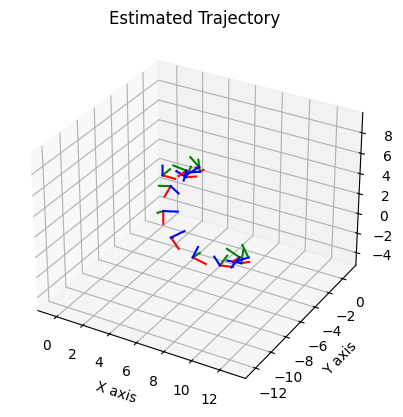

In [18]:
scenario = gtsam.ConstantTwistScenario(*scenarios["sick"])
plot_scenario(scenario, T, dt, title="Sick Scenario", fignum=15)

runner = gtsam.ScenarioRunner(scenario, pim_params, dt, actualBias)


graph = gtsam.NonlinearFactorGraph()
initial = gtsam.Values()

graph, initial = add_priors(scenario, graph, initial)
graph, initial = main_loop(runner, scenario, graph, initial, T)

optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, lm_params)
result = optimizer.optimize()

plot_trajectory(initial, title="Initial Trajectory", fignum=16, show=True)
plot_trajectory(result, fignum=17, show=True)

## Conclusion

There you have it! Using the `PreintegratedImuMeasurements` object and combining it with the `ImuFactor` gives us a powerful and efficient mechanism for performing inertial estimation. GTSAM gives us useful abstractions for dealing with IMU measurements at much higher rates than the estimation rate, and allows us to optimize for the correct trajectory.